In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.exceptions import ConvergenceWarning

In [2]:
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# df = pd.read_csv('../data/NumericalLoanData.csv', low_memory=False)
df = pd.read_csv('../data/ReducedLoanData_NoCathegory_Log.csv', low_memory=False)
x = df.drop(['Default', 'ES', 'FI', 'SK'], axis=1)
y = df['Default']
names = x.keys()
x.shape

(34745, 25)

In [3]:
def kfold(clf, x_, y_):
  n_folds = 10
  accuracies = []
  roc = []
  kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1)

  for train_index, test_index in kf.split(x_, y_):
    X_train, X_test = x_.iloc[train_index], x_.iloc[test_index]
    y_train, y_test = y_.iloc[train_index], y_.iloc[test_index]
      
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
      
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    y_probs = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    roc.append(roc_auc)

  mean_accuracy = np.mean(accuracies)
  std_accuracy = np.std(accuracies)
  print(f"Mean Accuracy: {mean_accuracy} std: {std_accuracy}")

  mean_accuracy = np.mean(roc)
  std_accuracy = np.std(roc)
  print(f"AUC Accuracy: {mean_accuracy} std: {std_accuracy}")

In [4]:
x_scaled = StandardScaler().fit_transform(x) 
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=1)

In [5]:
model = sm.Logit(y_train, x_train)
result = model.fit(method='newton')
result.params
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.640743
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                27796
Model:                          Logit   Df Residuals:                    27771
Method:                           MLE   Df Model:                           24
Date:                Mon, 01 Jan 2024   Pseudo R-squ.:                 0.06566
Time:                        07:11:06   Log-Likelihood:                -17810.
converged:                       True   LL-Null:                       -19062.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0380      0.016      2.354      0.019       0.006       0.070
x2             0.0983      0.

# Forward selection

In [183]:
clf = LogisticRegression()
sfs = SequentialFeatureSelector(clf, n_features_to_select=9, direction='forward', cv=5)
sfs.fit(x, y)
print()

In [184]:
selected_feature_indices = np.where(sfs.support_)[0]
selected_feature_names = x.keys()[selected_feature_indices]
selected_feature_names

Index(['Age', 'LoanDuration', 'LessThan3Years', 'MoreThan5Years',
       'Self-employed', 'Unemployed', 'Industry', 'Other', 'LessThan5Years'],
      dtype='object')

## K-fold on reduced features

In [185]:
x_forward = x[selected_feature_names]
clf = LogisticRegression()


In [186]:
kfold(clf, x_forward, y)

Mean Accuracy: 0.6271120637169021 std: 0.009012907382628863
AUC Accuracy: 0.6337972913886605 std: 0.007419937120479127


In [189]:
x_train_, x_test_, y_train_, y_test_ = train_test_split(x_forward, y, test_size=0.2, random_state=1)
model = sm.Logit(y_train_, x_train_)
result = model.fit(method='newton')
result.params
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.656879
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                Default   No. Observations:                27796
Model:                          Logit   Df Residuals:                    27787
Method:                           MLE   Df Model:                            8
Date:                Mon, 01 Jan 2024   Pseudo R-squ.:                 0.04213
Time:                        07:02:53   Log-Likelihood:                -18259.
converged:                       True   LL-Null:                       -19062.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age               -0.2210      0.012    -18.351      0.000      -0.245      -0.197
LoanDuration     

# Backward selection

In [13]:
clf = LogisticRegression()
sfs = SequentialFeatureSelector(clf, n_features_to_select=9, direction='backward', cv=10)
sfs.fit(x, y)
print()

In [16]:
selected_feature_indices = np.where(sfs.support_)[0]
selected_feature_indices
selected_feature_names = x.keys()[selected_feature_indices]
selected_feature_names

Index(['IncomeTotal', 'LiabilitiesTotal', 'LoanDuration', 'NewCreditCustomer',
       'Vocational', 'MoreThan5Years', 'Owner', 'Tenant', 'Single'],
      dtype='object')

In [17]:
x_backward = x[selected_feature_names]
clf = LogisticRegression()

ROC AUC Score: 0.6796996463773496


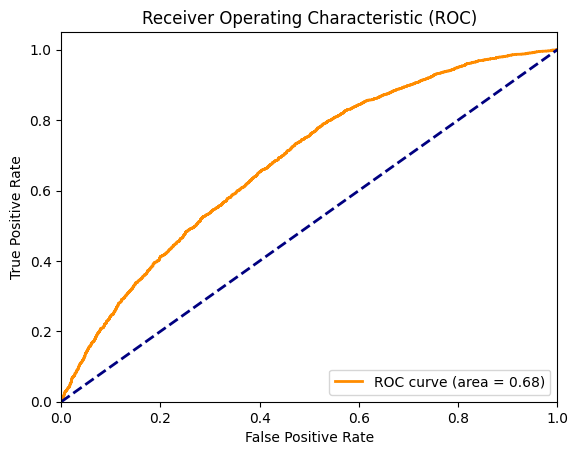

In [18]:
clf.fit(x_train[:, selected_feature_indices], y_train)
y_prob = clf.predict_proba(x_test[:, selected_feature_indices])[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

print("ROC AUC Score:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## K-fold on reduced features

In [19]:
kfold(clf, x_backward, y)

Mean Accuracy: 0.6399774191009887 std: 0.008388387874599855
AUC Accuracy: 0.6701573555912661 std: 0.011665710584621085


In [23]:
x_train_, x_test_, y_train_, y_test_ = train_test_split(x_backward, y, test_size=0.2, random_state=1)
model = sm.Logit(y_train_, x_train_)
result = model.fit(method='newton')
result.params
print(result.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

# K-fold cross validation on Logistic regression

In [6]:
clf = LogisticRegression()
kfold(clf, x, y)

Mean Accuracy: 0.6462227275174679 std: 0.010120910938786452
AUC Accuracy: 0.6805915265206595 std: 0.013058121210847371


# Lasso regularization

Alpha is set based on models_linear.ipynb 

In [7]:
lasso = Lasso(alpha=0.01)
lasso.fit(x_train, y_train)

feature_importance = lasso.coef_
arg_s = feature_importance.argsort()

# Print the feature importance scores
print("Feature Importance (Coefficients):")
for i, importance in enumerate(feature_importance[arg_s]):
    print(f"Feature {names[arg_s[i]]}: {importance}")

Feature Importance (Coefficients):
Feature Higher: -0.03067218414884775
Feature Secondary: -0.030612075510625125
Feature Owner: -0.014031129553806192
Feature Service: -0.0016825852922259272
Feature Age: 0.0
Feature Industry: -0.0
Feature Tenant: -0.0
Feature Male: 0.0
Feature Self-employed: -0.0
Feature MoreThan5Years: -0.0
Feature LessThan3Years: 0.0
Feature FreeCash: 0.0
Feature NrOfDependants: -0.0
Feature LessThan5Years: 0.0
Feature LiabilitiesTotal: 0.00038603407580180407
Feature Other: 0.0033545948197150227
Feature Unemployed: 0.005160255500063953
Feature Personal: 0.0059897300912549216
Feature DebtToIncome: 0.0075804655480204795
Feature Single: 0.014353018135856618
Feature Vocational: 0.015231579517612327
Feature AppliedAmount: 0.025015105191110516
Feature IncomeTotal: 0.030231558062008987
Feature NewCreditCustomer: 0.034001353127186204
Feature LoanDuration: 0.09652784532857567


In [8]:
from sklearn.linear_model import LassoCV

Accuracy: 0.6540509425816664
ROC AUC Score: 0.6864527522584578


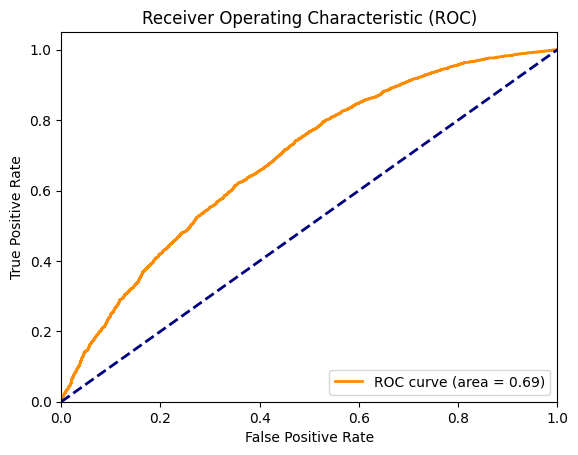

In [9]:
alphas = np.logspace(-2, 2, 100)
lasso_cv = LassoCV(alphas=alphas, cv=10)

lasso_cv.fit(x_train, y_train)

best_alpha = lasso_cv.alpha_

coefficients = lasso_cv.coef_

y_pred = lasso_cv.predict(x_test)

accuracy = accuracy_score(y_test, (y_pred >= 0.5).astype(int))
print("Accuracy:", accuracy)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Ridge

Alpha is set based on models_linear.ipynb 

In [10]:
ridge = Ridge(alpha=0.01)

# Fit the Ridge model to the data
ridge.fit(x_train, y_train)

# Get the coefficients of the features
coefficients = ridge.coef_

arg_so = coefficients.argsort()

# Print the coefficients
print("Coefficients:")
for i, coef in enumerate(coefficients[arg_so]):
    print(f"Feature {names[arg_so[i]]}: {coef}")

Coefficients:
Feature Higher: -0.056946437381352785
Feature Secondary: -0.05352086007697456
Feature Owner: -0.030832126633333786
Feature Tenant: -0.019517790224977606
Feature Service: -0.01647668001452996
Feature Industry: -0.013460031580866158
Feature MoreThan5Years: -0.009142897423757543
Feature Male: -0.001117889557878957
Feature Self-employed: -0.00023504981848696687
Feature LessThan3Years: 0.0001221050444546844
Feature NrOfDependants: 0.00018029084707003109
Feature Other: 0.0003671740867547951
Feature LessThan5Years: 0.0025099202137850367
Feature LiabilitiesTotal: 0.003504809707848554
Feature Vocational: 0.004159557607113354
Feature FreeCash: 0.004845339515429398
Feature Age: 0.008919863595332603
Feature Unemployed: 0.010884357818414328
Feature Personal: 0.015472146912657447
Feature Single: 0.020637796679452806
Feature AppliedAmount: 0.0227535138281035
Feature DebtToIncome: 0.028046294671821112
Feature NewCreditCustomer: 0.04468842611894881
Feature IncomeTotal: 0.05856816739753393

In [11]:
from sklearn.linear_model import RidgeCV

Accuracy: 0.650741113829328
ROC AUC Score: 0.6903864091811074


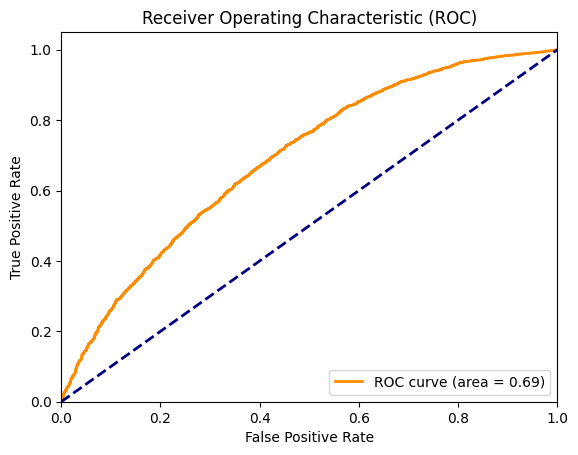

In [12]:
alphas = np.logspace(-2, 2, 100)
ridge_cv = RidgeCV(alphas=alphas, cv=10)
ridge_cv.fit(x_train, y_train)

best_alpha = ridge_cv.alpha_

y_pred = ridge_cv.predict(x_test)

accuracy = accuracy_score(y_test, (y_pred >= 0.5).astype(int))
print("Accuracy:", accuracy)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("ROC AUC Score:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# SVM

In [24]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

In [25]:
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)  # You can adjust C and gamma as needed

# Perform cross-validation
cv_scores = cross_val_score(svm_classifier, x, y, cv=8)  # You can adjust the number of folds (cv) as needed

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [0.6653 0.6463 0.7014 0.6017 0.6189 0.5678 0.6482 0.5752]
Mean Accuracy: 0.6280893021686853


In [26]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [27]:
svm_classifier.fit(x_train, y_train)

SVC(probability=True)

In [28]:
y_prob = svm_classifier.predict_proba(x_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)

ROC AUC Score: 0.7183656626879682


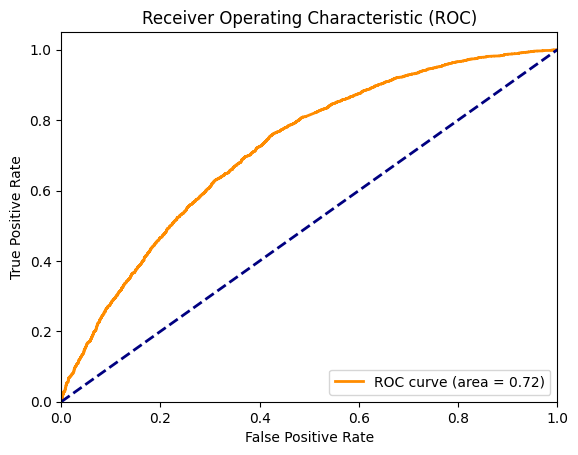

In [29]:
roc_auc = auc(fpr, tpr)

# Print ROC AUC score
print("ROC AUC Score:", roc_auc)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Logistic regression after lasso

In [118]:
x_drop = x.drop(names[arg_s[4:21]], axis=1)

In [119]:
x_drop

,AppliedAmount,IncomeTotal,LoanDuration,NewCreditCustomer,ES,FI,SK,Higher,Secondary,MoreThan5Years,Service
0,3.3276,2.5502,60,False,0,0,0,0,1,1,0
1,3.4773,2.9547,60,False,0,0,0,1,0,1,0
2,4.0266,3.0795,60,True,0,0,0,0,1,0,1
3,3.1764,2.9365,60,True,1,0,0,0,0,0,0
4,3.2030,2.8439,48,True,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
34740,3.3012,3.3619,60,True,0,1,0,0,0,0,0
34741,3.8716,3.3371,60,False,0,1,0,0,1,1,1
34742,3.2030,3.1906,60,False,1,0,0,0,0,1,1
34743,3.4773,2.5453,60,True,0,0,0,0,0,0,0


In [124]:
clf = LogisticRegression()
kfold(clf, x_drop, y)

Mean Accuracy: 0.6780254138657986 std: 0.009717959598510547
AUC Accuracy: 0.7292351240345467 std: 0.010971899916435462


# Pure log regression

In [182]:
clf = LogisticRegression()
kfold(clf, x, y)

Mean Accuracy: 0.6462227275174679 std: 0.010120910938786452
AUC Accuracy: 0.6805915265206595 std: 0.013058121210847371
